# MIMIC ML/DL PROJECT

In [68]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [69]:
# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

#@title Enter Google Cloud/BigQuery Project ID
project_id = 'valiant-monitor-450620-c4'

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

dataset_ref = bq_client.dataset('mimiciii_clinical', project='physionet-data')
bq_client.default_dataset = dataset_ref

## Sample query to test functional BigQuery Retrieval

In [70]:
query_1 = """
SELECT
    COUNT(DISTINCT subject_id) as total_patients,
    COUNT(*) as total_procedures
FROM
    physionet-data.mimiciii_clinical.procedures_icd
WHERE
    icd9_code BETWEEN '00' AND '86';
"""

# Execute query and convert to DataFrame
df = bq_client.query(query_1).to_dataframe()

# Display the DataFrame
print(df)

# Or for Jupyter notebook, just:
df  # This will show a nice formatted table in Jupyter

   total_patients  total_procedures
0           34889            142907


,total_patients,total_procedures
0,34889,142907


# Project Implementation

The idea of this project wil be attempting to use the MIMIC III data in combination with Machine Learning / Deep Learning methods to create a Diagnosis Assistance model to potentially automate certain diagnoses.

### Data Collection using BigQuery

In [71]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
project_id = 'valiant-monitor-450620-c4'
bq_client = bigquery.Client(project=project_id)
dataset_ref = bq_client.dataset('mimiciii_clinical', project='physionet-data')
bq_client.default_dataset = dataset_ref

In [73]:
# Query for extracting subset of diagnoses to predict
query_diagnosis = """
SELECT
  icd9_code,
  COUNT(*) as diagnosis_count,
  SHORT_TITLE
FROM
  physionet-data.mimiciii_clinical.diagnoses_icd
LEFT JOIN
  physionet-data.mimiciii_clinical.d_icd_diagnoses
USING (icd9_code)
GROUP BY
  icd9_code, SHORT_TITLE
ORDER BY
  diagnosis_count DESC
LIMIT 20;
"""

diagnosis_df = bq_client.query(query_diagnosis).to_dataframe()
print("Top 20 diagnoses in MIMICIII dataset")
diagnosis_df

Top 20 diagnoses in MIMICIII dataset


,icd9_code,diagnosis_count,SHORT_TITLE
0,4019,20703,Hypertension NOS
1,4280,13111,CHF NOS
2,42731,12891,Atrial fibrillation
3,41401,12429,Crnry athrscl natve vssl
4,5849,9119,Acute kidney failure NOS
5,25000,9058,DMII wo cmp nt st uncntr
6,2724,8690,Hyperlipidemia NEC/NOS
7,51881,7497,Acute respiratry failure
8,5990,6555,Urin tract infection NOS
9,53081,6326,Esophageal reflux


Here we have retrieved the top 20 most common diagnoses in the MIMIC III dataset, ordered by highest number of diagnoses. I will select the top 5 diagnoses for further analysis to simplify the data for model digestion.

In [74]:
# Specify top 5 for targeting
target_diagnoses = list(diagnosis_df['icd9_code'].iloc[:5])
target_diagnoses_names = list(diagnosis_df['SHORT_TITLE'].iloc[:5])
print(f"Selected diagnoses for prediction (ICD9 Code): {target_diagnoses}")
print(f"Selected diagnoses for prediction (name): {target_diagnoses_names}")

Selected diagnoses for prediction (ICD9 Code): ['4019', '4280', '42731', '41401', '5849']
Selected diagnoses for prediction (name): ['Hypertension NOS', 'CHF NOS', 'Atrial fibrillation', 'Crnry athrscl natve vssl', 'Acute kidney failure NOS']


In [75]:
# Filter the patient data with lab values and vital signs
query_patient_data = """
SELECT
  p.subject_id,
  p.gender,
  p.dob,
  a.hadm_id,
  a.admittime,
  DATETIME_DIFF(a.admittime, p.dob, YEAR) as age,
  d.icd9_code,
  d.seq_num as diagnosis_seq_num
FROM
  physionet-data.mimiciii_clinical.patients p
JOIN
  physionet-data.mimiciii_clinical.admissions a
ON
  p.subject_id = a.subject_id
JOIN
  physionet-data.mimiciii_clinical.diagnoses_icd d
ON
  a.hadm_id = d.hadm_id
WHERE
  d.icd9_code IN UNNEST(@target_codes)
  AND DATETIME_DIFF(a.admittime, p.dob, YEAR) > 0
ORDER BY
  p.subject_id, a.admittime
"""

# Configure the job to accept our target diagnoses as a parameter for analysis
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("target_codes", "STRING", target_diagnoses),
    ]
)

patient_diagnoses = bq_client.query(query_patient_data, job_config=job_config).to_dataframe()

print(f"Retrieved {len(patient_diagnoses)} diagnoses records...\nShowing Sample:\n")

patient_diagnoses.head()

Retrieved 68223 diagnoses records...
Showing Sample:



,subject_id,gender,dob,hadm_id,admittime,age,icd9_code,diagnosis_seq_num
0,3,M,2025-04-11,145834,2101-10-20 19:08:00,76,5849,3
1,3,M,2025-04-11,145834,2101-10-20 19:08:00,76,4280,6
2,9,M,2108-01-26,150750,2149-11-09 13:06:00,41,4280,3
3,9,M,2108-01-26,150750,2149-11-09 13:06:00,41,5849,4
4,9,M,2108-01-26,150750,2149-11-09 13:06:00,41,4019,6


In [76]:
# Next up will be to retrieve the lab values for these patients
# to provide some potential data that might help us
query_labs = """
SELECT
  l.subject_id,
  l.hadm_id,
  l.itemid,
  d.label as lab_name,
  l.charttime,
  l.valuenum,
  l.valueuom
FROM
  physionet-data.mimiciii_clinical.labevents l
JOIN
  physionet-data.mimiciii_clinical.d_labitems d
ON
  l.itemid = d.itemid
WHERE
  l.hadm_id IN UNNEST(@hadm_ids)
  AND l.valuenum IS NOT NULL
"""

# unique hadm_ids to remove duplicate admissions
hadm_ids = list(patient_diagnoses['hadm_id'].unique())
hadm_ids = [int(id) for id in hadm_ids]
print(f"Total unique admissions: {len(hadm_ids)}")

hadm_subset = hadm_ids[:1000]

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("hadm_ids", "INTEGER", hadm_subset),
    ]
)

lab_data = bq_client.query(query_labs, job_config=job_config).to_dataframe()
print(f"{len(lab_data)} lab record for {len(hadm_subset)} admissions analyzed")
lab_data.head()

Total unique admissions: 36890
453049 lab record for 1000 admissions analyzed


,subject_id,hadm_id,itemid,lab_name,charttime,valuenum,valueuom
0,773,170261,51200,Eosinophils,2109-02-18 07:59:00,0.0,%
1,782,163679,51200,Eosinophils,2176-03-04 11:40:00,0.0,%
2,149,154869,51200,Eosinophils,2135-02-18 09:50:00,0.0,%
3,1113,128609,51200,Eosinophils,2107-03-02 02:21:00,0.0,%
4,1326,123263,51200,Eosinophils,2132-10-02 17:30:00,0.0,%


In [77]:
# Next we'll extract the vital signs which we'll analyze later
query_vitals = """
SELECT
  c.subject_id,
  c.hadm_id,
  c.charttime,
  c.itemid,
  d.label as vital_sign,
  c.valuenum,
  c.valueuom
FROM
  physionet-data.mimiciii_clinical.chartevents c
JOIN
  physionet-data.mimiciii_clinical.d_items d
ON
  c.itemid = d.itemid
WHERE
  c.hadm_id IN UNNEST(@hadm_ids)
  AND c.valuenum IS NOT NULL
  AND d.category IN ('Vital Signs', 'General', 'Labs')
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("hadm_ids", "INTEGER", hadm_subset),
    ]
)

vital_data = bq_client.query(query_vitals, job_config=job_config).to_dataframe()
print(f"{len(vital_data)} vital sign records retreived")
vital_data.head()

18240 vital sign records retreived


,subject_id,hadm_id,charttime,itemid,vital_sign,valuenum,valueuom
0,773,170261,2109-03-08 04:46:00,225643,Differential-Neuts,1.0,%
1,605,149601,2197-12-06 12:22:00,225640,Differential-Eos,0.6,%
2,773,170261,2109-02-23 04:00:00,227440,Digoxin,0.6,ng/mL
3,357,117876,2199-12-31 02:58:00,220581,Amylase,35.0,IU/L
4,502,116367,2143-10-25 03:44:00,220632,LDH,501.0,IU/L


In [78]:
print(f"Top 20 lab tests:\n{lab_data['lab_name'].value_counts().head(20)}")

Top 20 lab tests:
lab_name
Glucose                 18296
pH                      15679
Hematocrit              15627
Potassium               14820
Hemoglobin              14752
Creatinine              13762
Urea Nitrogen           13698
Sodium                  13548
Chloride                13364
Bicarbonate             13338
Platelet Count          13134
Anion Gap               13010
Calculated Total CO2    12750
pO2                     12749
pCO2                    12747
Base Excess             12746
Magnesium               12742
White Blood Cells       12544
MCHC                    12402
Red Blood Cells         12396
Name: count, dtype: int64


In [79]:
print(f"Top 20 vital signs:\n{vital_data['vital_sign'].value_counts().head(20)}")

Top 20 vital signs:
vital_sign
Glucose finger stick     937
Hematocrit (serum)       709
Potassium (serum)        655
Sodium (serum)           628
Glucose (serum)          628
Chloride (serum)         625
PH (Arterial)            606
HCO3 (serum)             606
Creatinine               603
BUN                      603
Anion gap                601
Magnesium                599
Arterial CO2 Pressure    594
Arterial O2 pressure     594
Arterial Base Excess     594
TCO2 (calc) Arterial     594
Platelet Count           566
Phosphorous              557
Calcium non-ionized      555
Hemoglobin               540
Name: count, dtype: int64


In [80]:
print(f"Unique vital options: \n{vital_data['vital_sign'].unique()}")

Unique vital options: 
['Differential-Neuts' 'Differential-Eos' 'Digoxin' 'Amylase' 'LDH'
 'Vancomycin (Trough)' 'Specific Gravity (urine)' 'Called Out'
 'PH (dipstick)' 'Differential-Lymphs' 'Albumin' 'Differential-Bands'
 'Admission Weight (Kg)' 'LDL calculated' 'ICU Consent Signed'
 'Differential-Basos' 'Feeding Weight' 'Ammonia' 'Differential-Monos'
 'Mixed Venous O2% Sat' 'Lipase' 'PO2 (Mixed Venous)' 'Differential-Atyps'
 'Fibrinogen' 'D-Dimer' 'Hematocrit (whole blood - calc)'
 'Sodium (whole blood)' 'Vancomycin (Random)' 'Phenytoin (Dilantin)'
 'PH (Venous)' 'Direct Bilirubin' 'Venous CO2 Pressure' 'Height'
 'Cortisol' 'Chloride (whole blood)' 'Height (cm)' 'Venous O2 Pressure'
 'Cholesterol' 'Legal Guardian' 'Tobramycin (Trough)'
 'Central Venous O2% Sat' 'CK-MB fraction (%)' 'Blood Transfusion Consent'
 'Triglyceride' 'C Reactive Protein (CRP)' 'TCO2 (calc) Venous'
 'Gentamicin (Peak)' 'Brain Natiuretic Peptide (BNP)' 'Sed Rate'
 'Estimated Energy Needs/Kg' 'Total Protein' 'U

### Feature Engineering


In [81]:
# Specifying the common lab tests and vital signs to filter what
# might be useful for diagnosis prediction
important_labs = [
    'GLUCOSE', 'POTASSIUM', 'SODIUM', 'CHLORIDE', 'CREATININE',
    'BICARBONATE', 'WHITE BLOOD CELLS', 'HEMOGLOBIN', 'PLATELET COUNT',
    'MAGNESIUM', 'CALCIUM, TOTAL', 'PHOSPHATE', 'LACTATE', 'HEMATOCRIT',
    'ANION GAP', 'INR(PT)', 'PT', 'PTT'
]
important_vitals = [
    'Glucose finger stick', 'BUN', 'Hematocrit (serum)', 'Potassium (serum)', 'Sodium (serum)',
    'Glucose (serum)', 'Chloride (serum)', 'PH (Arterial)', 'HCO3 (serum)','Creatinine',
    'BUN', 'Anion gap', 'Magnesium', 'Arterial CO2 Pressure', 'Arterial O2 pressure',
    'Arterial Base Excess', 'TCO2 (calc) Arterial', 'Platelet Count', 'Phosphorous',
    'Calcium non-ionized', 'Hemoglobin'
]

# Helper function for feature extraction
def create_features_for_admission(hadm_id, lab_df, vital_df):
  patient_labs = lab_df[lab_df['hadm_id'] == hadm_id]

  # get values for each lab test
  lab_features = {}
  for lab in important_labs:
    lab_rows = patient_labs[patient_labs['lab_name'].str.contains(lab, case=False, na=False)]
    if len(lab_rows) > 0:
      first_value = lab_rows.iloc[0]['valuenum']
      lab_features[f'lab_{lab.replace(",","").replace(" ", "_").replace("(", "").replace(")", "").lower()}'] = first_value # remove commas replace spaces w/underlines

    else:
      lab_features[f'lab_{lab.replace(",","").replace(" ", "_").replace("(", "").replace(")", "").lower()}'] = np.nan

  # aget values for vitals
  patient_vitals = vital_df[vital_df['hadm_id'] == hadm_id]

  vital_features = {}
  for vital in important_vitals:
    vital_rows = patient_vitals[patient_vitals['vital_sign'].str.contains(vital, case=False, na=False)]
    if len(vital_rows) > 0:
      first_value = vital_rows.iloc[0]['valuenum']
      vital_features[f'vital_{vital.replace(",","").replace(" ","_").replace("(", "").replace(")", "").lower()}'] = first_value
    else:
      vital_features[f'vital_{vital.replace(",","").replace(" ","_").replace("(", "").replace(")", "").lower()}'] = np.nan

  all_features = {**lab_features, **vital_features}
  return all_features

# Creating features for each admit
feature_list = []
diagnoses_list = []

# unique hadm_ids with primary diagnosis
primary_diagnoses = patient_diagnoses.sort_values(['hadm_id', 'diagnosis_seq_num']).drop_duplicates('hadm_id')


# Processing each admit
for idx, row in primary_diagnoses.iterrows():
  if row['hadm_id'] in hadm_subset:
    features = create_features_for_admission(row['hadm_id'], lab_data, vital_data)
    features['hadm_id'] = row['hadm_id']
    features['subject_id'] = row['subject_id']
    features['gender'] = 1 if row['gender'] == 'M' else 0
    features['age'] = row['age']
    feature_list.append(features)
    diagnoses_list.append(row['icd9_code'])

# creating the features df
features_df = pd.DataFrame(feature_list)
print(f"Created features for {len(features_df)} admits")

<ipython-input-81-9b09d11f0ee8>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lab_rows = patient_labs[patient_labs['lab_name'].str.contains(lab, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  vital_rows = patient_vitals[patient_vitals['vital_sign'].str.contains(vital, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lab_rows = patient_labs[patient_labs['lab_name'].str.contains(lab, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  vital_rows = patient_vitals[patient_

Created features for 1000 admits


<ipython-input-81-9b09d11f0ee8>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lab_rows = patient_labs[patient_labs['lab_name'].str.contains(lab, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  vital_rows = patient_vitals[patient_vitals['vital_sign'].str.contains(vital, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lab_rows = patient_labs[patient_labs['lab_name'].str.contains(lab, case=False, na=False)]
<ipython-input-81-9b09d11f0ee8>:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  vital_rows = patient_vitals[patient_

In [83]:
features_df['diagnosis'] = diagnoses_list

# Basic data cleaning
# Fill missing values with median
numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['hadm_id', 'subject_id', 'diagnosis']]

for col in numeric_cols:
    features_df[col] = features_df[col].fillna(features_df[col].median())

# Display feature statistics
print("\nFeature statistics:")
print(features_df[numeric_cols].describe())

# Encode target diagnoses
features_df['diagnosis_code'] = features_df['diagnosis'].astype('category').cat.codes
print("\nDiagnosis distribution:")
print(features_df['diagnosis'].value_counts())


Feature statistics:
       lab_glucose  lab_potassium   lab_sodium  lab_chloride  lab_creatinine  \
count  1000.000000    1000.000000  1000.000000   1000.000000     1000.000000   
mean    131.893000       4.295400   137.177000    102.953000        5.168300   
std      67.734212       3.082421    10.908926      8.137875       27.176663   
min      37.000000       1.700000    13.000000     21.000000        0.100000   
25%      98.000000       3.700000   136.000000    100.000000        0.700000   
50%     118.000000       4.000000   138.000000    103.000000        1.000000   
75%     147.250000       4.400000   141.000000    107.000000        1.500000   
max    1000.000000      75.000000   158.000000    130.000000      462.000000   

       lab_bicarbonate  lab_white_blood_cells  lab_hemoglobin  \
count      1000.000000            1000.000000     1000.000000   
mean         25.046000              10.991200       10.593900   
std           4.778359               8.914949        1.999473  

### Random Forest Classifier

In [84]:
X = features_df[numeric_cols]
y = features_df['diagnosis_code']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling of featurs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier

# Initialize + train

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred = rf_model.predict(X_test_scaled)

print("Model Eval:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model Eval:
              precision    recall  f1-score   support

           0       0.42      0.51      0.46        39
           1       0.53      0.57      0.55        46
           2       0.18      0.06      0.09        32
           3       0.35      0.48      0.40        50
           4       0.57      0.39      0.46        33

    accuracy                           0.42       200
   macro avg       0.41      0.40      0.39       200
weighted avg       0.41      0.42      0.41       200



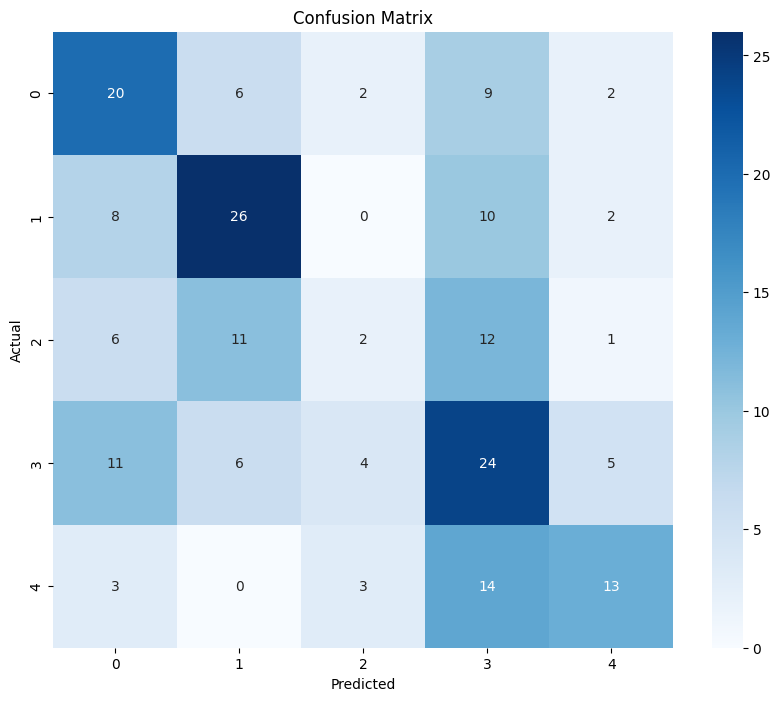

In [85]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

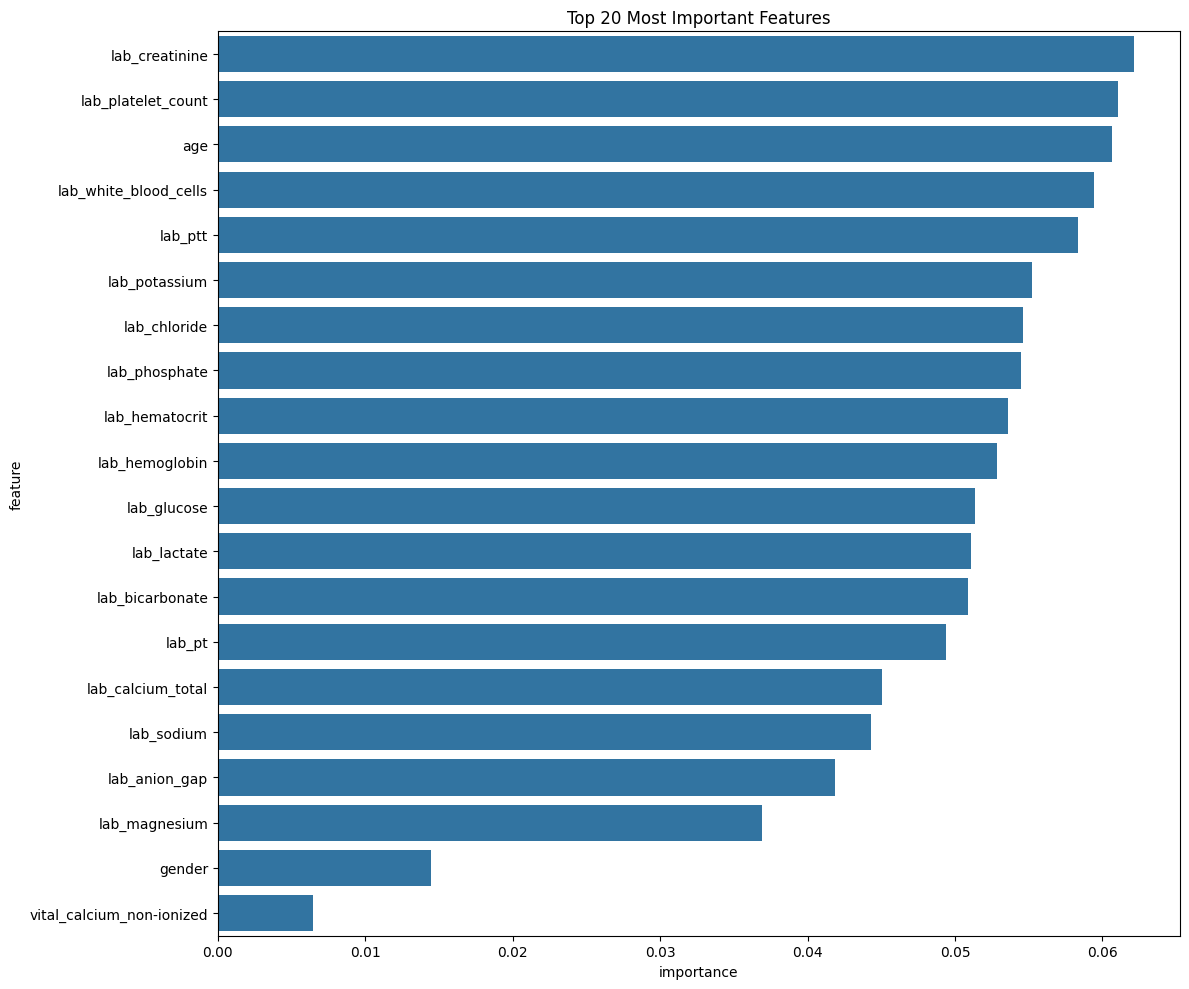

In [89]:
# Feature importance
plt.figure(figsize=(12, 10))
feat_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feat_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [91]:
from xgboost import XGBClassifier

# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
print("XGBoost:\n", classification_report(y_test, xgb_pred))

XGBoost:
               precision    recall  f1-score   support

           0       0.44      0.44      0.44        39
           1       0.42      0.48      0.44        46
           2       0.21      0.16      0.18        32
           3       0.30      0.34      0.32        50
           4       0.37      0.30      0.33        33

    accuracy                           0.35       200
   macro avg       0.35      0.34      0.34       200
weighted avg       0.35      0.35      0.35       200

